In [6]:
# INSTALLING THE LIBRARIES:
import torch
import numpy as np
import torch
from torch.nn import functional as F
from d2l import torch as d2l

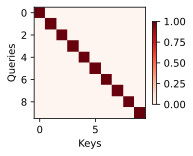

In [5]:
# FUNCTION FOR VISUALIZATION:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
    """Heatmaps of matrices"""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


# INSPECTING THE FUNCTION:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel="Keys", ylabel="Queries")


**Kernels and Data**

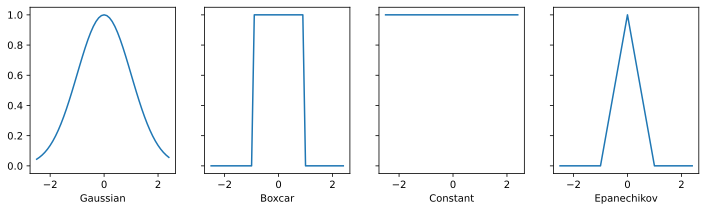

In [7]:
# INSPECTING KERNELS:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# DEFINING KERNELS:
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ("Gaussian", "Boxcar", "Constant", "Epanechikov")

x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

**Nadaraya-Watson Estimation**

In [8]:
# INITIALIZING TRAINING DATA:
def func(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = func(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = func(x_val)

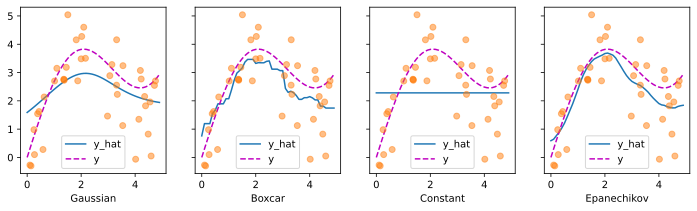

In [9]:
# DEFINING NADARAYA WATSON FUNCTION:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0) # normalization over keys for each query. 
    y_hat = y_train@attention_w
    return y_hat, attention_w


# INSPECTING THE ESTIMATION:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap="Reds")
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, "m--")
            ax.plot(x_train, y_train, "o", alpha=0.5)
        ax.set_xlabel(name)
        if not attention:
            ax.legend(["y_hat", "y"])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)


# INSPECTION:
plot(x_train, y_train, x_val, y_val, kernels, names)

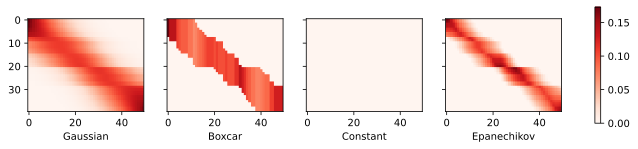

In [10]:
# INSPECTION:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)